# <b>FrozenLake 4x4 Environment</b>

In this colab notebook, we'll implement an agent <b>that plays FrozenLake.</b>

![alt text](http://simoninithomas.com/drlc/Qlearning/frozenlake4x4.png)

The goal of this game is <b>to go from the starting state (S) to the goal state (G)</b> by walking only on frozen tiles (F) and avoid holes (H). However, the ice is slippery, **so you won't always move in the direction you intend (stochastic environment)**

Reference: https://github.com/simoninithomas/Deep_reinforcement_learning_Course

## Step 0: Install the dependencies on Google Colab

In [2]:
#!pip install numpy
#!pip install gym==0.19.0
#!pip install gym
#!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Step 1: Import the dependencies 📚
We use 4 libraries:
- `numpy` for Q-table
- `random` for random number generation
- `OpenAI Gym` for FrozenLake Environment
- `tqdm` for visualizing loop progress
- `matplotlib` for graph visualization

In [1]:
import gym
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## Step 2: Create the environment 🎮
- Here we'll create the FrozenLake 4x4 environment.
- We can see the map via <b>env.render()</b>

In [2]:
env = gym.make("FrozenLake-v1")

print('There are total {} states'.format(env.observation_space.n))
print('There are total {} actions'.format(env.action_space.n))

env.render()

There are total 16 states
There are total 4 actions

SFFF
FHFH
FFFH
HFFG


  - Now we apply some random actions, and see what environment returns!


In [3]:
state = env.reset()
print('initial state: ', state)
env.render()
action = random.randint(0, 3)
print('random action: ', action)
next_state, reward, done, _ = env.step(action)
print('next state: {}, reward: {}, game ended: {}'.format(next_state, reward, done))
env.render()

initial state:  0

SFFF
FHFH
FFFH
HFFG
random action:  0
next state: 0, reward: 0.0, game ended: False
  (Left)
SFFF
FHFH
FFFH
HFFG


## Step 3: Recall preview Learning in Monte-Carlo: 🗄️
### Step 3-1: Create empty Q-table
  - <b>Q-table:</b> used to record value of action given state

In [4]:
# state space, action space
nS, nA = env.observation_space.n, env.action_space.n
# create empty Q-table
Q = np.zeros((nS, nA), dtype=np.float64)
print(Q)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Step 3-2: set hyperparameters ⚙️
- Here, we'll specify the hyperparameters
  - `max_steps`: maximum number of steps that agent can take in each episode
  - `n_episodes`: total number of episodes that agent will play to learn Q-table
  - `𝛼`: learning rate; balancing old Q-value and new Q-value
  - `𝛾`: gamma, discount rate
- There are some parameters about exploration:
  - `epsilon`: exploration rate, decay over episodes

In [5]:
## in each episode, max step is 100
max_steps = 100
## we will run total 10,000 episodes
n_episodes = 100000

gamma = 1.0

def decay_schedule(max_value, min_value, decay_ratio, steps, log_start=-2, log_base=10):
    decay_steps = int(steps * decay_ratio)
    rem_steps = steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (max_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

# exploration rate, epsilon
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay_ratio = 0.9
epsilons = decay_schedule(max_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

# learning rate, alphas:
max_alpha = 0.7
min_alpha = 0.1
alpha_decay_ratio = 0.9
alphas = decay_schedule(max_alpha, min_alpha, alpha_decay_ratio, n_episodes)

## Step 4: Learn Until Converge 🧠
### step 4-1: SARSA
SARSA is an abbreviation of State-Action-Reward-State-Action.

![alt_text](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb06Fqy%2FbtqFNOZ84N8%2F1y0yu0IVuHpec9wzd7LHM0%2Fimg.png)

In [7]:
# q-table for SARSA
sarsa_Q = np.zeros((nS, nA))

# record episode rewards
sarsa_epi_rew = []

# play n_episodes
for e in tqdm(range(n_episodes), leave=False):
    # Reset the environment
    state = env.reset()
    done = False
    
    # take initial action using epsilon-greedy        
    if random.random() < epsilons[e]:
        action = random.randint(0, 3)
    else:
        action = np.argmax(sarsa_Q[state])

    for step in range(max_steps):
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        next_state, reward, done, _ = env.step(action)

        # sarsa_Q[next_state,:] all the actions we can take from new state
        # sample next_action using epsilon-greedy        
        if random.random() < epsilons[e]:
            next_action = random.randint(0, 3)
        else:
            next_action = np.argmax(sarsa_Q[state])
        
        # Update Q-table
        sarsa_Q[state][action] = sarsa_Q[state][action] \
        + alphas[e] * (reward + gamma * sarsa_Q[next_state][next_action] - sarsa_Q[state][action])

        # state transition
        state = next_state
        action = next_action

        # If done: finish episode
        if done: 
            break
        
    # append episode reward for performance visualization
    sarsa_epi_rew.append(reward)
    

print('Learned Q-table:')
print(sarsa_Q)
print('Learned Value of states:')
print(np.sum(sarsa_Q, axis=1))

Learned Q-table:
[[0.03057896 0.02779553 0.02877719 0.02856985]
 [0.01786376 0.01408097 0.01212931 0.02677273]
 [0.03199842 0.0222253  0.02681433 0.02168413]
 [0.01454176 0.0197265  0.01708465 0.02173883]
 [0.02760323 0.02794022 0.02578476 0.02425828]
 [0.         0.         0.         0.        ]
 [0.04188801 0.10213541 0.04064354 0.01356947]
 [0.         0.         0.         0.        ]
 [0.01723857 0.04580742 0.03962778 0.05363448]
 [0.16418019 0.16945715 0.17686413 0.05320024]
 [0.23516387 0.20409509 0.21146264 0.04657688]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.15813369 0.40671886 0.43684337 0.30120493]
 [0.47414785 0.64744584 0.73149147 0.5298076 ]
 [0.         0.         0.         0.        ]]
Learned Value of states:
[0.11572152 0.07084678 0.10272217 0.07309175 0.10558647 0.
 0.19823642 0.         0.15630826 0.56370171 0.69729848 0.
 0.         1.30290085 2.38289276 0.        ]


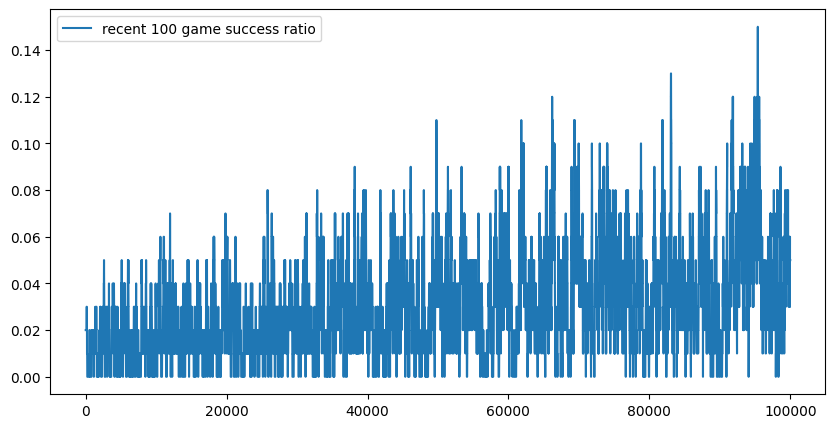

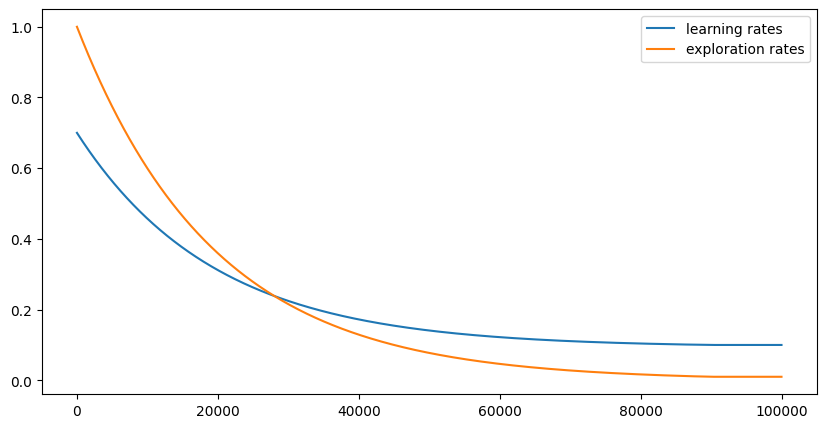

In [8]:
# success rate of recent [window_size] games
window_size = 100
plt.figure(figsize=(10, 5))
plt.plot([np.mean(sarsa_epi_rew[:window_size]) for i in range(window_size)] + [np.mean(sarsa_epi_rew[i - window_size:i]) for i in range(window_size, len(sarsa_epi_rew))], label='recent {} game success ratio'.format(window_size))
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(alphas, label='learning rates')
plt.plot(epsilons, label='exploration rates')
plt.legend()
plt.show()
plt.close()

## Step 5: Play with learnt Q-table! 👾
- <b>Exploitation:</b> follow the Q-table

### step 5-1: play with SARSA Q-table:

In [25]:
for episode in range(5):
  state = env.reset()
  done = False
  print("****************************************************")
  print("EPISODE ", episode)

  for step in range(max_steps):
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(sarsa_Q[state])
      
    next_state, reward, done, info = env.step(action)
    
    if done:
      # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
      env.render()
      if next_state == 15:
          print("We reached our Goal 🏆")
      else:
          print("We fell into a hole ☠️")
      
      # We print the number of step it took.
      print("Number of steps", step)
      
      break
    state = next_state
env.close()

****************************************************
EPISODE  0
  (Right)
SFFF
FHFH
FFFH
HFFG
We fell into a hole ☠️
Number of steps 6
****************************************************
EPISODE  1
  (Down)
SFFF
FHFH
FFFH
HFFG
We fell into a hole ☠️
Number of steps 14
****************************************************
EPISODE  2
  (Down)
SFFF
FHFH
FFFH
HFFG
We fell into a hole ☠️
Number of steps 4
****************************************************
EPISODE  3
  (Right)
SFFF
FHFH
FFFH
HFFG
We reached our Goal 🏆
Number of steps 11
****************************************************
EPISODE  4
  (Right)
SFFF
FHFH
FFFH
HFFG
We reached our Goal 🏆
Number of steps 19
